In [1]:
import os
from os.path import join
import chess.pgn
import numpy as np
import json
import requests
from bs4 import BeautifulSoup
from requests_html import HTMLSession
from joblib import Parallel, delayed
from tqdm import tqdm
from irl_chess.misc_utils.utils import union_dicts
from irl_chess.chess_utils.sunfish_utils import board2sunfish, eval_pos, sunfish_move_to_str, str_to_sunfish_move, get_new_pst
from irl_chess.chess_utils.sunfish import piece, pst
from irl_chess.models.sunfish_GRW import sunfish_move
from collections import defaultdict
from irl_chess.misc_utils.load_save_utils import fix_cwd, load_config, get_board_after_n, get_states

[D:matplotlib] matplotlib data path: %s
[D:matplotlib] CONFIGDIR=%s
[D:matplotlib] interactive is %s
[D:matplotlib] platform is %s
[D:matplotlib] CACHEDIR=%s
[D:matplotlib.font_manager] Using fontManager instance from %s


In [2]:
with open('data/move_percentages/moves_1000-1200_fixed', 'r') as f:
    moves_dict = json.load(f)
n_boards = 500
sunfish_boards = [board2sunfish(fen, 0) for fen in list(moves_dict.keys())[:n_boards]]
move_dicts = [move_dict for fen, move_dict in list(moves_dict.items())[:n_boards]]
player_moves = [max(move_dict, key=lambda k: move_dict[k][0] - (k == 'sum')) for move_dict in move_dicts]

In [16]:
R = np.array([100, 280, 320, 479, 929, 60000])
pst_new = get_new_pst(R)
actions_true = Parallel(n_jobs=-2)(delayed(sunfish_move)(state, pst_new, 0.5, move_only=True)
                        for state in tqdm(sunfish_boards, desc='Getting true moves', ))


Getting true moves:  27%|██▋       | 133/500 [00:27<01:35,  3.83it/s]

KeyboardInterrupt: 

In [28]:
R = np.array([100, 200, 200, 479, 929, 60000])
pst_new = get_new_pst(R)
moves = Parallel(n_jobs=-2)(delayed(sunfish_move)(state, pst, 0.5, move_only=True)
                    for state in tqdm(sunfish_boards, desc='Getting new actions'))
moves = [sunfish_move_to_str(move) for move in moves]
acc = sum([a == a_new for a, a_new in list(zip(player_moves, moves))]) / n_boards
print(acc)





Getting new actions:   0%|          | 0/500 [00:00<?, ?it/s]



Getting new actions:   3%|▎         | 14/500 [00:00<00:21, 22.60it/s]



Getting new actions:   4%|▍         | 21/500 [00:01<00:45, 10.53it/s]



Getting new actions:   6%|▌         | 28/500 [00:02<00:49,  9.48it/s]



Getting new actions:   7%|▋         | 35/500 [00:03<00:49,  9.38it/s]



Getting new actions:   8%|▊         | 42/500 [00:04<00:46,  9.91it/s]



Getting new actions:  10%|▉         | 49/500 [00:05<00:54,  8.27it/s]



Getting new actions:  11%|█         | 56/500 [00:06<00:56,  7.88it/s]



Getting new actions:  13%|█▎        | 63/500 [00:06<00:52,  8.31it/s]



Getting new actions:  14%|█▍        | 70/500 [00:08<01:02,  6.85it/s]



Getting new actions:  15%|█▌        | 77/500 [00:09<00:56,  7.44it/s]



Getting new actions:  17%|█▋        | 84/500 [00:09<00:54,  7.66it/s]



Getting new actions:  18%|█▊        | 91/500 [00:10<00:55,  7.31it/s]



Getting new actions:  20%|█▉        | 98/500 [00:11<00:5

0.472


In [8]:
with open('experiment_configs\\depths\\config_lower.json', 'r') as file:
    config_lower = json.load(file)
print(config_lower)
    
with open('experiment_configs\\depths\\config_upper.json', 'r') as file:
    config_upper = json.load(file)
print(config_upper)

{'time_limit': 200, 'R_true': [100, 280, 320, 479, 929, 60000], 'overwrite': False, 'n_files': 3, 'min_elo': 800, 'max_elo': 1200, 'n_midgame': 15, 'n_endgame': 30, 'n_boards': 1000, 'n_threads': -2, 'move_function': 'player_move', 'move_percentage_data': False}
{'time_limit': 200, 'R_true': [100, 280, 320, 479, 929, 60000], 'overwrite': False, 'n_files': 3, 'min_elo': 1600, 'max_elo': 1800, 'n_midgame': 15, 'n_endgame': 30, 'n_boards': 1000, 'n_threads': -2, 'move_function': 'player_move', 'move_percentage_data': False}


In [9]:
websites_filepath = join(os.getcwd(), 'downloads', 'lichess_websites.txt')
file_path_data = join(os.getcwd(), 'data', 'raw')

sunfish_boards_lower, player_moves_lower = get_states(websites_filepath=websites_filepath,
                                                        file_path_data=file_path_data,
                                                        config_data=config_lower)
player_moves_lower = [sunfish_move_to_str(move) for move in player_moves_lower]

print('Got lower, now upper')

sunfish_boards_upper, player_moves_upper = get_states(websites_filepath=websites_filepath,
                                                        file_path_data=file_path_data,
                                                        config_data=config_upper)
player_moves_upper = [sunfish_move_to_str(move) for move in player_moves_upper]



-------------------  1/12  -------------------


Time taken: 0.00 seconds for file
Time taken: 0.00 seconds in total


-------------------  2/12  -------------------


Time taken: 0.00 seconds for file
Time taken: 0.00 seconds in total


-------------------  3/12  -------------------


Time taken: 0.00 seconds for file
Time taken: 0.00 seconds in total
C:\Users\nikol\Documents\GitHub\irl-chess\data\raw\lichess_db_standard_rated_2013-01.pgn


Looking through file 0: 100%|██████████| 92811021/92811021 [08:56<00:00, 172935.14it/s]


C:\Users\nikol\Documents\GitHub\irl-chess\data\raw\lichess_db_standard_rated_2014-01.pgn


Looking through file 1:   8%|▊         | 47917332/574506567 [05:46<1:03:25, 138366.10it/s]


Got lower, now upper


-------------------  1/12  -------------------


Time taken: 0.00 seconds for file
Time taken: 0.00 seconds in total


-------------------  2/12  -------------------


Time taken: 0.00 seconds for file
Time taken: 0.00 seconds in total


-------------------  3/12  -------------------


Time taken: 0.00 seconds for file
Time taken: 0.00 seconds in total
C:\Users\nikol\Documents\GitHub\irl-chess\data\raw\lichess_db_standard_rated_2013-01.pgn


Looking through file 0:   4%|▍         | 3708614/92811021 [00:22<09:10, 161753.32it/s]


In [10]:
def correct_at_depth(player_move, state, depth):
    move = sunfish_move(state, pst, time_limit=200, max_depth=depth, move_only=True)
    #top_5_moves = top_k_moves(move_dict, 5)
    return player_move == sunfish_move_to_str(move)

n_threads = config_lower['n_threads']
n_boards = config_lower['n_boards']
with Parallel(n_jobs=n_threads) as parallel:
    depths = [1,2,3,4,5]
    depth_scores_lower = [0] * len(depths)
    depth_scores_upper = [0] * len(depths)
    for i, depth in enumerate(depths):
        print(f'\n Depth: {depth} \n', '-'*20)
        correct_lower = parallel(delayed(correct_at_depth)(player_move, state, depth)
                                 for player_move, state in tqdm(list(zip(player_moves_lower, sunfish_boards_lower))))
        correct_upper = parallel(delayed(correct_at_depth)(player_move, state, depth)
                                 for player_move, state in tqdm(list(zip(player_moves_upper, sunfish_boards_upper))))
        depth_scores_lower[i] = sum(correct_lower)/n_boards
        depth_scores_upper[i] = sum(correct_upper)/n_boards
lower_min_elo = config_lower['min_elo']
lower_max_elo = config_lower['max_elo']
upper_min_elo = config_upper['min_elo']
upper_max_elo = config_upper['max_elo']
print(f'Depth scores for ELO {lower_min_elo}-{lower_max_elo}: {depth_scores_lower}')
print(f'Depth scores for ELO {upper_min_elo}-{upper_max_elo}: {depth_scores_upper}')


 Depth: 1 
 --------------------


100%|██████████| 1000/1000 [00:04<00:00, 201.29it/s]



 Depth: 2 
 --------------------


100%|██████████| 1000/1000 [00:48<00:00, 20.45it/s]



 Depth: 3 
 --------------------


100%|██████████| 1000/1000 [01:53<00:00,  8.82it/s]



 Depth: 4 
 --------------------


100%|██████████| 1000/1000 [07:55<00:00,  2.11it/s]



 Depth: 5 
 --------------------


100%|██████████| 1000/1000 [20:25<00:00,  1.23s/it]


Depth scores for ELO 800-1200: [0.307, 0.294, 0.29, 0.288, 0.285]
Depth scores for ELO 1600-1800: [0.339, 0.343, 0.363, 0.364, 0.366]


In [32]:
i = 20
print(actions[i])
_, _, move_dict = sunfish_move(states[i], pst, 1000, max_depth=4)
moves = set([sunfish_move_to_str(move) for move in move_dict.keys()])
print(actions[i] in moves)

b1c3


KeyboardInterrupt: 

In [8]:
actions.index('d1e2')

8

{'g1f3': [0.42, 1873], 'd1e2': [0.16, 702], 'h2h3': [0.07, 294], 'b1c3': [0.05, 220], 'c1f4': [0.05, 220], 'd3d4': [0.05, 211], 'g1e2': [0.04, 179], 'c1e3': [0.04, 164], 'c2c4': [0.03, 126], 'd1f3': [0.02, 103], 'c2c3': [0.02, 101], 'a2a3': [0.01, 31], 'sum': [1.0, 4410]}


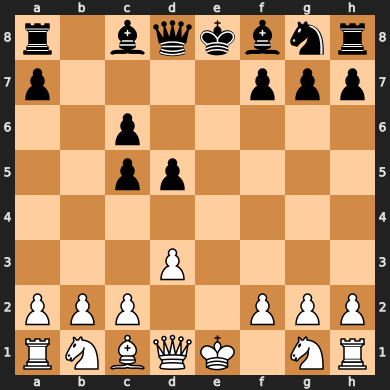

In [10]:

stop = False
for i, (pos, moves) in enumerate(moves_dict.items()):
    board = chess.Board(pos)
    legal_moves = {move.uci() for move in list(board.legal_moves)}
    if not board.turn:
        stop = True
    for move in list(moves.keys()):
        if move not in legal_moves and move != 'sum':
            print(f'Move {move} not in {legal_moves}, fen: {fen}')
            stop = True
            break
    if stop:
        'Whoops'
        break
print(moves)
board

In [6]:
!pip install selenium

  Using cached h11-0.14.0-py3-none-any.whl.metadata (8.2 kB)
   ---------------------------------------- 0.0/10.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.5 MB 960.0 kB/s eta 0:00:11
   ---------------------------------------- 0.1/10.5 MB 1.3 MB/s eta 0:00:09
    --------------------------------------- 0.2/10.5 MB 1.3 MB/s eta 0:00:08
    --------------------------------------- 0.2/10.5 MB 1.3 MB/s eta 0:00:08
   - -------------------------------------- 0.3/10.5 MB 1.4 MB/s eta 0:00:08
   - -------------------------------------- 0.4/10.5 MB 1.3 MB/s eta 0:00:08
   - -------------------------------------- 0.5/10.5 MB 1.5 MB/s eta 0:00:07
   -- ------------------------------------- 0.5/10.5 MB 1.5 MB/s eta 0:00:07
   -- ------------------------------------- 0.6/10.5 MB 1.6 MB/s eta 0:00:07
   -- ------------------------------------- 0.7/10.5 MB 1.6 MB/s eta 0:00:07
   --- ------------------------------------ 0.8/10.5 MB 1.6 MB/s eta 0:00:06
   --- -------------

In [9]:
def top_k_moves(move_dict, k, verbose=False):
    score_matrix = np.zeros((len(move_dict), 200), dtype=float) - np.inf
    for i, (move, scores) in enumerate(move_dict.items()):
        score_matrix[i, :len(scores)] = scores
    moves_at_depth = (score_matrix != -np.inf).sum(axis=0)
    top_moves_depth = sum(moves_at_depth > k)
    top_moves_idxs = np.where(score_matrix[:, top_moves_depth] != -np.inf)[0]
    if verbose:
        print('Intermediary moves')
        print({sunfish_move_to_str(move) for i, move in enumerate(move_dict) if i in top_moves_idxs}, '\n')
    score_matrix[top_moves_idxs, top_moves_depth-1] = -np.inf
    missing_moves = k - len(top_moves_idxs)
    if verbose:
        print(missing_moves)
    if missing_moves:
        top_moves_idxs = np.append(top_moves_idxs, score_matrix[:, top_moves_depth-1].argsort()[-missing_moves:])
    return {sunfish_move_to_str(move) for i, move in enumerate(move_dict) if i in top_moves_idxs}

In [13]:
pgn = open("data/raw/lichess_db_standard_rated_2013-01.pgn")
failures = 0
for i in tqdm(range(100)):
    game = chess.pgn.read_game(pgn)
    board = game.board()
    state, player_move = get_board_after_n(game, 15)
    sf_state = board2sunfish(state, 300)
    if not state.turn:
        state = state.transform(chess.flip_horizontal)
        state.apply_mirror()
    player_move = sunfish_move_to_str(player_move)
    move, best_moves, move_dict = sunfish_move(sf_state, pst, 0.5, move_only=False)
    best_moves = {sunfish_move_to_str(move) for move in best_moves.keys()}
    top_moves = top_k_moves(move_dict, len(best_moves))
    if not top_moves == best_moves:
        print('Failure')
        failures += 1
print(f'{failures}/100')

  4%|▍         | 4/100 [00:04<01:39,  1.04s/it]

Failure


  7%|▋         | 7/100 [00:07<01:38,  1.06s/it]

Failure


  9%|▉         | 9/100 [00:08<01:26,  1.05it/s]

Failure


 25%|██▌       | 25/100 [00:20<00:55,  1.35it/s]

Failure


 35%|███▌      | 35/100 [00:31<00:55,  1.17it/s]

Failure


 47%|████▋     | 47/100 [00:41<00:40,  1.31it/s]

Failure


 53%|█████▎    | 53/100 [00:45<00:30,  1.53it/s]

Failure


 58%|█████▊    | 58/100 [00:51<00:56,  1.35s/it]

Failure


 74%|███████▍  | 74/100 [01:05<00:18,  1.40it/s]

Failure


 77%|███████▋  | 77/100 [01:07<00:17,  1.30it/s]

Failure


 86%|████████▌ | 86/100 [01:14<00:13,  1.04it/s]

Failure


 99%|█████████▉| 99/100 [01:28<00:01,  1.13s/it]

Failure


100%|██████████| 100/100 [01:29<00:00,  1.11it/s]

12/100


100%|██████████| 7/7 [00:00<00:00, 301.59it/s]


Sunfish best move: h4g6
Sunfish moves: {'f4c7', 'f1d3', 'c3d5', 'h4g6', 'h4f5'}
Player move: h4g6


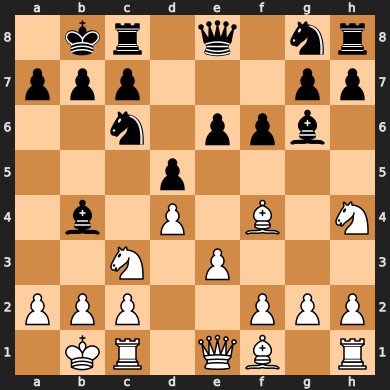

In [34]:
pgn = open("data/raw/lichess_db_standard_rated_2013-01.pgn")
failures = 0
for i in tqdm(range(7)):
    game = chess.pgn.read_game(pgn)
    board = game.board()
    state, player_move = get_board_after_n(game, 15)
    if not state.turn:
        state = state.transform(chess.flip_horizontal)
        state.apply_mirror()
    player_move = sunfish_move_to_str(player_move)
    sf_state = board2sunfish(state, 0)

move, best_moves, move_dict = sunfish_move(sf_state, pst, time_limit=200, max_depth=3, move_only=False)
print(f'Sunfish best move: {sunfish_move_to_str(move)}')
print(f'Sunfish moves: {top_k_moves(move_dict, 5)}')
print(f'Player move: {player_move}')

state

In [39]:
[print(sunfish_move_to_str(move), score) for move, score in best_moves.items()]

h4g6 25
f1d3 29


[None, None]

In [46]:
[print(sunfish_move_to_str(move), scores) for move, scores in move_dict.items()]

h4g6 [25, 407, 407, 155, 155, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 57, 155, 155, 155, 155, 57, 57, 57, 57, 57, 57]
c3d5 [130, -270, -270, -270, -270, -270, -270, -270, -270, -270, -270, -270, -270]
f4c7 [-70, -70, -70, -70, -70, -70, -70, 182, 182, -70, -70, -70]
h4f5 [41, -171, -171, -171, -171, -171, -171, -171, -171, -171, -171, -171]
f1c4 [32, -169, -169, -169, -169, -169, 108, 108, 108, -169, -169]
f1b5 [23, 23, 23, 23, 23, 386, 153, 85, 85, 64]
f1d3 [29, 36, 36, 36, 36, 36, 36, 36, 36, 32, 32, 32, 32, 32, 32]
f4d6 [67, 67, -185, -185, 67, 67, 67, 67, 67]
c1d1 [162, 83, 41, 41, 407, 130, 105, 41, 41]
f1e2 [161, 82, 40, 40, 406, 129, 104, 40, 40]
e1d1 [157, 82, 36, 36, 402, 125, 100, 36, 36]
e1e2 [155, 80, 34, 34, 400, 123, 98, 34, 34]
e3e4 [155, 76, 55, 23, 155, 155, 76, 76, 55]
h4f3 [75, 75, -8, -8, 122, 122, 97, 24, 24]
e1d2 [151, 60, 30, 30, 396, 119, 119, 30, 30]
h2h3 [151, 72, 30, 30, 396, 119, 119, 30, 30]
f2f3 [151, 72, 30, 30, 396, 119, 119, 30, 30]
c3b5 [-389, -389, -3

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [7]:
pgn = open("data/raw/lichess_db_standard_rated_2013-01.pgn")
failures = 0
depths = [1,2,3,4,5,6]
depth_scores = [0] * len(depths)
for i in tqdm(range(100), desc='Iterating through states'):
    game = chess.pgn.read_game(pgn)
    board = game.board()
    state, player_move = get_board_after_n(game, 15)
    sf_state = board2sunfish(state, 300)
    player_move = sunfish_move_to_str(player_move)
    for i, depth in enumerate(depths):
        move, best_moves, move_dict = sunfish_move(sf_state, pst, time_limit=200, max_depth=depth, move_only=False)
        top_5_moves = top_k_moves(move_dict, 5)
        depth_scores[i] += player_move in top_5_moves
print(depth_scores)

Iterating through states:   0%|          | 0/100 [00:00<?, ?it/s]


NameError: name 'top_k_moves' is not defined

In [41]:
pgn = open("data/raw/lichess_db_standard_rated_2014-01.pgn")
elos = []
for i in tqdm(range(5000), desc='Iterating through states'):
    game = chess.pgn.read_game(pgn)
    try:
        elos.append(int(game.headers['WhiteElo']))
    except ValueError:
        continue
elos = np.array(elos)

Iterating through states: 100%|██████████| 5000/5000 [00:14<00:00, 342.54it/s]


In [42]:
sum(elos<1000)

2

In [6]:
len(player_moves_upper)

500

In [3]:
pgn = open("data/raw/lichess_db_standard_rated_2013-01.pgn")
for i in tqdm(range(100), desc='Iterating through states'):
    game = chess.pgn.read_game(pgn)
    board = game.board()
    state, player_move = get_board_after_n(game, 3)

Iterating through states: 100%|██████████| 100/100 [00:00<00:00, 348.67it/s]


In [5]:
from requests_html import AsyncHTMLSession
import nest_asyncio
import os

os.environ['PYPPETEER_CHROMIUM_REVISION'] = '1263111'

nest_asyncio.apply()

site = 'https://lichess.org/analysis/standard/'
fen = state.fen()
url = site + fen

asession = AsyncHTMLSession()
r = await asession.get(url)
await r.html.arender()
resp=r.html.raw_html
r.html.render()
soup = BeautifulSoup(r.content)


[D:urllib3.connectionpool] Starting new HTTPS connection (%d): %s:%s
[D:urllib3.connectionpool] %s://%s:%s "%s %s %s" %s %s
[D:websockets.client] = connection is CONNECTING
[D:websockets.client] > GET %s HTTP/1.1
[D:websockets.client] > %s: %s
[D:websockets.client] > %s: %s
[D:websockets.client] > %s: %s
[D:websockets.client] > %s: %s
[D:websockets.client] > %s: %s
[D:websockets.client] > %s: %s
[D:websockets.client] > %s: %s
[D:websockets.client] < HTTP/1.1 %d %s
[D:websockets.client] < %s: %s
[D:websockets.client] < %s: %s
[D:websockets.client] < %s: %s
[D:websockets.client] < %s: %s
[D:websockets.client] = connection is OPEN
[D:websockets.client] > %s
[D:websockets.client] < %s
[D:websockets.client] < %s
[D:websockets.client] < %s
[D:websockets.client] < %s
[D:websockets.client] > %s
[D:websockets.client] < %s
[D:websockets.client] < %s
[D:websockets.client] < %s
[D:websockets.client] > %s
[D:websockets.client] < %s
[D:websockets.client] < %s
[D:websockets.client] < %s
[D:websockets

RuntimeError: Cannot use HTMLSession within an existing event loop. Use AsyncHTMLSession instead.

In [23]:
!pip install pyppeteer==1.0.0

   ---------------------------------------- 0.0/83.5 kB ? eta -:--:--
   ---- ----------------------------------- 10.2/83.5 kB ? eta -:--:--
   ------------------- -------------------- 41.0/83.5 kB 495.5 kB/s eta 0:00:01
   ---------------------------------------- 83.5/83.5 kB 671.7 kB/s eta 0:00:00
  Attempting uninstall: pyee
    Found existing installation: pyee 11.1.0
    Uninstalling pyee-11.1.0:
      Successfully uninstalled pyee-11.1.0
  Attempting uninstall: pyppeteer
    Found existing installation: pyppeteer 2.0.0
    Uninstalling pyppeteer-2.0.0:
      Successfully uninstalled pyppeteer-2.0.0


In [47]:
with open('data/move_percentages/moves_1000-1200', 'r') as f:
    moves_dict = json.load(f)

In [72]:
list(moves_dict.items())[4]

('rn1qk2r/pbpp1pbp/1p2p2p/8/2B1P3/3P1Q1N/PPP2PPP/RN2K2R w KQkq - 2 7',
 {'c2c3': [0.5, 127],
  'b1c3': [0.17, 42],
  'h3f4': [0.09, 24],
  'f3g3': [0.06, 14],
  'g2g4': [0.04, 9],
  'f3g4': [0.02, 6],
  'd3d4': [0.02, 4],
  'a2a4': [0.01, 2],
  'b1d2': [0.01, 2],
  'f3h5': [0.0, 1],
  'a2a3': [0.0, 1],
  'sum': [1.0, 254],
  'e1g1': [0.08, 20]})

In [73]:
for i, (pos, moves) in enumerate(moves_dict.items()):
    board = chess.Board(pos)
    for move in list(moves.keys()):
        if move == 'e1h1':
            from_square = chess.Move.from_uci(move).from_square
            piece = board.piece_type_at(from_square)
            piece_notation = chess.piece_name(piece).upper()
            print(i, move, piece_notation)
            if piece_notation == 'KING':
                moves['e1g1'] = moves.pop(move)
        elif move == 'e1a1':
            from_square = chess.Move.from_uci(move).from_square
            piece = board.piece_type_at(from_square)
            piece_notation = chess.piece_name(piece).upper()
            print(i, move, piece_notation)
            if piece_notation == 'KING':
                moves['e1c1'] = moves.pop(move)

55 e1a1 KING
60 e1a1 KING
135 e1a1 KING
291 e1a1 KING
373 e1a1 KING
884 e1a1 KING
1014 e1a1 KING
1202 e1a1 KING
1365 e1a1 KING
1380 e1a1 KING
1423 e1a1 KING
1528 e1a1 KING
1751 e1a1 KING
1883 e1a1 KING
2031 e1a1 KING
2049 e1a1 KING
2060 e1a1 KING
2063 e1a1 KING
2189 e1a1 KING
2422 e1a1 KING
2440 e1a1 KING
2553 e1a1 KING
2557 e1a1 KING
2577 e1a1 KING
2612 e1a1 KING
2639 e1a1 KING
2698 e1a1 KING
2810 e1a1 KING
2867 e1a1 KING
2901 e1a1 KING
2993 e1a1 KING
3272 e1a1 KING
3339 e1a1 KING
3343 e1a1 KING
3375 e1a1 KING
3423 e1a1 KING
3432 e1a1 KING
3538 e1a1 KING
3546 e1a1 KING
3568 e1a1 KING
3615 e1a1 KING
3644 e1a1 KING
3725 e1a1 KING
3757 e1a1 KING
3844 e1a1 KING
4023 e1a1 KING
4079 e1a1 KING
4288 e1a1 KING
4749 e1a1 KING
4883 e1a1 KING
4961 e1a1 KING
5011 e1a1 KING
5039 e1a1 KING
5048 e1a1 KING
5109 e1a1 KING
5120 e1a1 KING
5226 e1a1 KING
5332 e1a1 KING
5346 e1a1 KING
5390 e1a1 KING
5628 e1a1 KING
5676 e1a1 KING
5769 e1a1 KING
5827 e1a1 KING
5909 e1a1 KING
6023 e1a1 KING
6095 e1a1 KING
614

r n . q k . . r
p b p p . p b p
. p . . p . . p
. . . . . . . .
. . B . P . . .
. . . P . Q . N
P P P . . P P P
R N . . K . . R
{'h3g5', 'f3f5', 'c4a6', 'c4e6', 'e4e5', 'b2b4', 'b2b3', 'h3f4', 'a2a4', 'b1d2', 'b1c3', 'f3h5', 'e1f1', 'c2c3', 'f3g4', 'e1g1', 'c4d5', 'e1e2', 'f3f6', 'e1d2', 'f3e2', 'c4b3', 'f3f7', 'g2g3', 'f3e3', 'b1a3', 'h3g1', 'f3f4', 'f3g3', 'g2g4', 'd3d4', 'h1g1', 'a2a3', 'f3d1', 'c4b5', 'h1f1', 'e1d1'}
['c2c3', 'b1c3', 'h3f4', 'f3g3', 'g2g4', 'f3g4', 'd3d4', 'a2a4', 'b1d2', 'f3h5', 'a2a3', 'sum', 'e1g1']


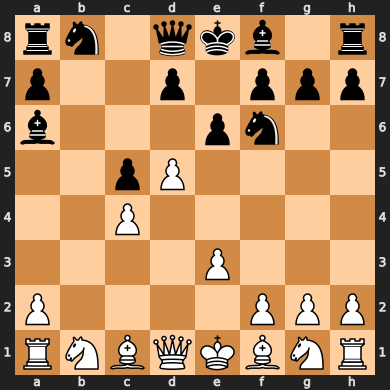

In [88]:
stop = False
bad_fens = []
for i, (fen, moves) in enumerate(moves_dict.items()):
    board = chess.Board(fen)
    legal_moves = {move.uci() for move in list(board.legal_moves)}
    if not board.turn:
        bad_fens.append(fen)
        continue
    for move in list(moves.keys()):
        if move not in legal_moves and move != 'sum':
            print(f'Move {move} not in {legal_moves}, fen: {fen}')
            stop = True
            break
    if i == 4:
        print(board)
        print(legal_moves)
        print(list(moves.keys()))
    if stop:
        break
board

In [84]:
print(len(moves_dict))
for fen in bad_fens:
    del moves_dict[fen]
print(len(moves_dict))

9993


KeyError: 'r1bqkb1r/ppp2ppp/2np1n2/4p3/2B1P3/5N1P/PPPP1PP1/RNBQ1RK1 b kq - 2 5'

In [85]:
list(moves_dict.items())[4]

('rn1qk2r/pbpp1pbp/1p2p2p/8/2B1P3/3P1Q1N/PPP2PPP/RN2K2R w KQkq - 2 7',
 {'c2c3': [0.5, 127],
  'b1c3': [0.17, 42],
  'h3f4': [0.09, 24],
  'f3g3': [0.06, 14],
  'g2g4': [0.04, 9],
  'f3g4': [0.02, 6],
  'd3d4': [0.02, 4],
  'a2a4': [0.01, 2],
  'b1d2': [0.01, 2],
  'f3h5': [0.0, 1],
  'a2a3': [0.0, 1],
  'sum': [1.0, 254],
  'e1g1': [0.08, 20]})

In [83]:
file_path = 'data/move_percentages/moves_1000-1200_fixed'
with open(file_path, 'w') as f:
    json.dump(moves_dict, f)

In [34]:
!pip install -r maia_chess/requirements.txt

  Using cached humanize-4.9.0-py3-none-any.whl.metadata (7.9 kB)
  Using cached tensorboard-2.16.2-py3-none-any.whl.metadata (1.6 kB)
  Using cached tensorflow-2.16.1-cp310-cp310-win_amd64.whl.metadata (3.5 kB)
  Using cached tensorboardX-2.6.2.2-py2.py3-none-any.whl.metadata (5.8 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached grpcio-1.63.0-cp310-cp310-win_amd64.whl.metadata (3.3 kB)
  Using cached Markdown-3.6-py3-none-any.whl.metadata (7.0 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
  Using cached werkzeug-3.0.2-py3-none-any.whl.metadata (4.1 kB)
  Using cached tensorflow_intel-2.16.1-cp310-cp310-win_amd64.whl.metadata (5.0 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached gast-0.5.4-py3-none-any.whl.metadata (1.3 kB)
  Using cach

In [35]:
from maia_chess import load_maia_network
model = load_maia_network(1100, parent='maia_chess/')

[D:asyncio] Using proactor: %s
[D:chess.engine] %s: Connection made
[D:chess.engine] %s: << %s
[D:chess.engine] %s: >> %s
[D:chess.engine] %s: >> %s
[D:chess.engine] %s: >> %s
[D:chess.engine] %s: >> %s
[D:chess.engine] %s: >> %s
[D:chess.engine] %s: >> %s
[D:chess.engine] %s: >> %s
[D:chess.engine] %s: >> %s
[D:chess.engine] %s: >> %s
[D:chess.engine] %s: >> %s
[D:chess.engine] %s: >> %s
[D:chess.engine] %s: >> %s
[D:chess.engine] %s: >> %s
[D:chess.engine] %s: >> %s
[D:chess.engine] %s: >> %s
[D:chess.engine] %s: >> %s
[D:chess.engine] %s: >> %s
[D:chess.engine] %s: >> %s
[D:chess.engine] %s: >> %s
[D:chess.engine] %s: >> %s
[D:chess.engine] %s: >> %s
[D:chess.engine] %s: >> %s
[D:chess.engine] %s: >> %s
[D:chess.engine] %s: >> %s
[D:chess.engine] %s: >> %s
[D:chess.engine] %s: >> %s
[D:chess.engine] %s: >> %s
[D:chess.engine] %s: >> %s
[D:chess.engine] %s: >> %s
[D:chess.engine] %s: >> %s
[D:chess.engine] %s: >> %s
[D:chess.engine] %s: >> %s
[D:chess.engine] %s: >> %s
[D:chess.engin

Model loaded successfully!


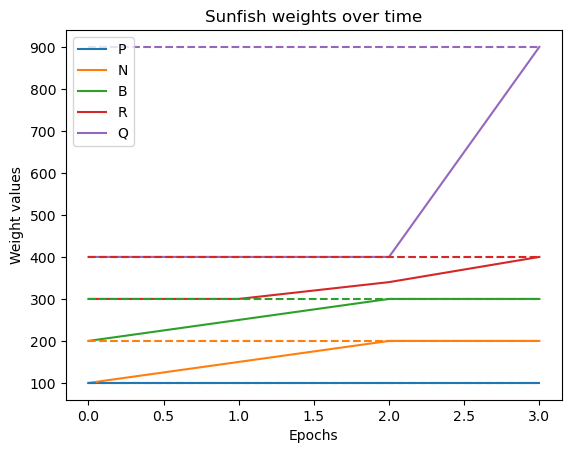

In [23]:
import matplotlib.pyplot as plt

R_true = np.array([100,200,300,400,900])
Rs = np.array([[100,100,200,300,400],
               [100,150,250,300,400],
               [100,200,300,340,400],
               [100,200,300,400,900],])
accs = np.array([0.2,0.3,0.5,0.8])

def simply_plot_R(Rs, R_true, out_path, epoch):
    plot_path = os.path.join(out_path, 'plots')
    default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    pieces = ['P','N','B','R','Q']
    plt.plot(Rs)
    plt.hlines(R_true, 0, len(Rs)-1, linestyles='--', colors = default_colors)
    plt.title('Sunfish weights over time')
    plt.xlabel('Epochs')
    plt.ylabel('Weight values')
    plt.legend(pieces)
    plt.savefig(join(plot_path, f'weights_{epoch}.png'))
    plt.cla()

simply_plot_R(Rs, R_true)

Text(0, 0.5, 'Accuracy')

[D:matplotlib.font_manager] findfont: Matching %s.
[D:matplotlib.font_manager] findfont: score(%s) = %s
[D:matplotlib.font_manager] findfont: score(%s) = %s
[D:matplotlib.font_manager] findfont: score(%s) = %s
[D:matplotlib.font_manager] findfont: score(%s) = %s
[D:matplotlib.font_manager] findfont: score(%s) = %s
[D:matplotlib.font_manager] findfont: score(%s) = %s
[D:matplotlib.font_manager] findfont: score(%s) = %s
[D:matplotlib.font_manager] findfont: score(%s) = %s
[D:matplotlib.font_manager] findfont: score(%s) = %s
[D:matplotlib.font_manager] findfont: score(%s) = %s
[D:matplotlib.font_manager] findfont: score(%s) = %s
[D:matplotlib.font_manager] findfont: score(%s) = %s
[D:matplotlib.font_manager] findfont: score(%s) = %s
[D:matplotlib.font_manager] findfont: score(%s) = %s
[D:matplotlib.font_manager] findfont: score(%s) = %s
[D:matplotlib.font_manager] findfont: score(%s) = %s
[D:matplotlib.font_manager] findfont: score(%s) = %s
[D:matplotlib.font_manager] findfont: score(%s) 

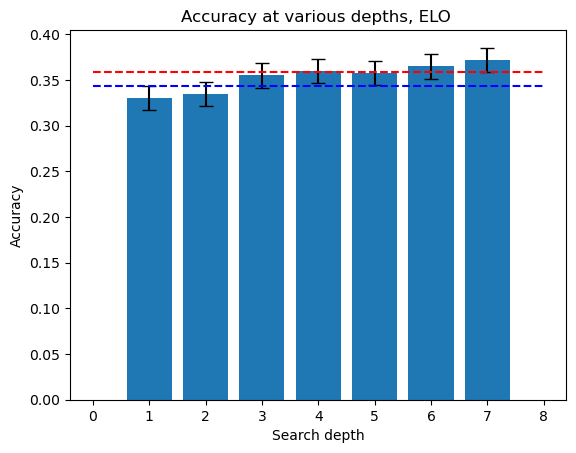

In [21]:
import matplotlib.pyplot as plt

n = 5000
depth_accs_low = np.array([0.329, 0.325, 0.3306, 0.337, 0.342, 0.337, 0.337])
depth_accs_high = np.array([0.33, 0.335, 0.355, 0.36, 0.358, 0.365, 0.372])
depth_accs = [depth_accs_low, depth_accs_high]

accs = depth_accs_high

errors = 1.96 * np.sqrt((accs*(1-accs))/n)
plt.bar(np.arange(len(accs))+1, accs, yerr=errors, capsize = 5)
plt.hlines([max(accs-errors), min(accs+errors)],xmin=0, xmax=len(accs)+1,
           linestyles='--', colors=['red','blue'])
plt.title('Accuracy at various depths, ELO ')
plt.xlabel('Search depth')
plt.ylabel('Accuracy')

In [7]:
errors

array([0.00028846, 0.00028665, 0.00028917, 0.00029195, 0.00029405,
       0.00029195, 0.00029195])

In [22]:
board

NameError: name 'board' is not defined